# Part 2: Modeling & Evaluation

## Imports

In [1]:
# Standard Imports
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

# Modeling, Evaluation, & Appearance
from keras                   import regularizers
from keras.models            import Sequential
from keras.layers            import Dense
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics         import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing   import StandardScaler
from IPython.core.display    import display, HTML
from IPython.display         import display_html

# Custom Modules
import graphs
from metrics                 import binary_classification_summary, confusion_matrix_dataframe
from metrics                 import specificity


# Notebook settings
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Setting a seed for the models
np.random.seed(42)

Using TensorFlow backend.
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Table Of Contents

- [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    

- [Establishing The Baseline](#Establishing-The-Baseline)
    
    
- [Preprocessing](#Preprocessing)
    - [Feature Engineering](#Feature-Engineering)
        - [Data Manipulation](#Data-Manipulation)
        - [Interaction Columns](#Interaction-Columns)
    - [Subset Definition](#Subset-Definition)
    - [Defining X & y Variables](#Defining-X-&-y-Variables)
    - [Train-Test Split](#Train-Test-Split)
    - [Scaling The Data](#Scaling-The-Data)

  
- [Modeling](#Modeling)
    - [Evaluation Functions](#Evaluation-Functions)
    - [Neural Networks](#Neural-Networks)
        - [Original Features](#Original-Features)
        - [Squared Features](#Squared-Features)
        - [Interaction Features](#Interaction-Features)
        
        
- [Evaluation](#Evaluation)
    - [Dataframes](#Dataframes)
    - [Best Model Selection](#Best-Model-Selection)
    - [Plots](#Plots)
        - [Bar Chart](#Bar-Chart)
        - [ROC Curve](#ROC-Curve)

## Reading In The Data

In [2]:
pulsar = pd.read_csv("../Data/pulsar_cleaned.csv")

### Overview

In [3]:
# Checking the head of the data

pulsar.head()

,mean_ip,sd_ip,ex_kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,ex_kurt_dmsnr,skew_dmsnr,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
# Checking the shape of the data

print(f"The shape of the dataset is: {pulsar.shape}")

The shape of the dataset is: (17898, 9)


In [5]:
# Summary of column data types

pulsar.dtypes.value_counts()

float64    8
int64      1
dtype: int64

In [6]:
# Checking for null values

pulsar.isnull().sum()

mean_ip          0
sd_ip            0
ex_kurt_ip       0
skew_ip          0
mean_dmsnr       0
sd_dmsnr         0
ex_kurt_dmsnr    0
skew_dmsnr       0
target_class     0
dtype: int64

[Top](#Table-Of-Contents)

## Establishing The Baseline

We need to know what our baseline accuracy is because that will give us an accuracy score to beat: if our accuracy is less than the baseline it means that our model is worse than guessing the category of a star.

In [7]:
# Calculating the percentages of each class

round(pulsar["target_class"].value_counts(normalize = True)*100, 2)

0    90.84
1     9.16
Name: target_class, dtype: float64

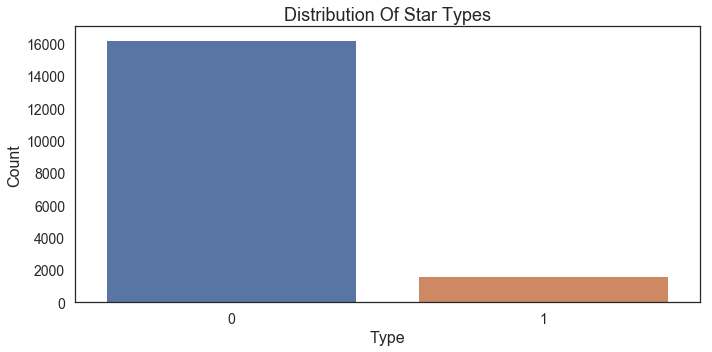

In [8]:
graphs.countplots(df      = pulsar,
                  columns = ["target_class"],
                  titles  = ["Distribution Of Star Types"],
                  ylabel  = "Count",
                  labels  = ["Type"],
                  dim     = (10,5),
                  row     = 1,
                  col     = 1)

`0` represents a normal star and `1` represents a pulsar which is our target.

It is readily apparent that the data is _extremely_ imbalanced: this will make it difficult to model because the negative class (non-pulsar) is so much less frequent than the positive class (pulsar).

## Preprocessing

### Feature Engineering

#### Data Manipulation

While visualizing the data, we noticed that there are two columns that appeared to have a close to normal distribution.  As a result, we decided to square the values to transform them.

In [9]:
# Squaring the `mean_ip` column

pulsar["mean_ip_squared"] = pulsar["mean_ip"].apply(lambda x: x**2)

# Squaring the `sd_ip` column

pulsar["sd_ip_squared"]   = pulsar["sd_ip"].apply(lambda x: x**2)

In [10]:
# Making sure new columns were added

pulsar.columns

Index(['mean_ip', 'sd_ip', 'ex_kurt_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr',
       'ex_kurt_dmsnr', 'skew_dmsnr', 'target_class', 'mean_ip_squared',
       'sd_ip_squared'],
      dtype='object')

#### Interaction Columns

Based off the heat map in the previous notebook, we noticed that there are some columns with very high correlations.  We felt that creating interaction columns, we would be emphasizing the correlation while also reducing the number of features.


The columns are:


| Column 1   | Column 2   | Correlation |
|:-----------|:-----------|:-----------:|
| mean_ip    | sd_ip      | 0.55        |
| ex_kurt_ip | skew_ip    | 0.95        |
| mean_dmsnr | sd_dmsnr   | 0.80        |
| ex_kurt_ip | skew_dmsnr | 0.92        |


We chose these columns because they have very strong correlations and only creating four does not dramatically increase the number of features in our model.  

However, instead of having one set of features we decided to create three subsets:


- original features


- squared features


- original features with interaction columns

In [11]:
# Defining the `mean_ip` * `sd_ip` colum
# Defining the `ex_kurt_ip` * `skew_ip` colum

pulsar["mean_*_sd_ip"]     = pulsar["mean_ip"] * pulsar["sd_ip"]
pulsar["exkurt_*_skew_ip"] = pulsar["ex_kurt_ip"] * pulsar["skew_ip"]

# Defining the `mean_dmsnr` * `sd_dmsnr` colum
# Defining the `ex_kurt_dmsnr` * `skew_dmsnr` colum

pulsar["mean_*_sd_dmsnr"]     = pulsar["mean_dmsnr"] * pulsar["sd_dmsnr"]
pulsar["exkurt_*_skew_dmsnr"] = pulsar["ex_kurt_dmsnr"] * pulsar["skew_dmsnr"]

In [12]:
# Checking to make sure columns were created

pulsar.columns

Index(['mean_ip', 'sd_ip', 'ex_kurt_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr',
       'ex_kurt_dmsnr', 'skew_dmsnr', 'target_class', 'mean_ip_squared',
       'sd_ip_squared', 'mean_*_sd_ip', 'exkurt_*_skew_ip', 'mean_*_sd_dmsnr',
       'exkurt_*_skew_dmsnr'],
      dtype='object')

[Top](#Table-Of-Contents)

### Subset Definition

We decided that because of the extreme imbalance of the classes a feed forward neural network is the best approach to predicting the a pulsar.

Because of the way we set up the interaction columns and manipulated the data, we decided that we are best off with three subsets: the original features, original features with squared columns, and the interaction columns.  We must define the subsets before we define our X and y variables.

In [13]:
# List of the original features

original_features    = ["mean_ip", "sd_ip", "ex_kurt_ip", "skew_ip",
                        "mean_dmsnr", "sd_dmsnr", "ex_kurt_dmsnr", "skew_dmsnr",
                        "target_class"]

# List of the original features with `mean_ip` and `sd_ip` squared

manipulated_features = ["mean_ip_squared", "sd_ip_squared", "ex_kurt_ip", "skew_ip",
                        "mean_dmsnr", "sd_dmsnr", "ex_kurt_dmsnr", "skew_dmsnr",
                        "target_class"]

# List of the interaction features

interaction_features = ["mean_ip", "sd_ip", "ex_kurt_ip", "skew_ip",
                        "mean_dmsnr", "sd_dmsnr", "ex_kurt_dmsnr", 
                        "skew_dmsnr", "mean_*_sd_ip", "exkurt_*_skew_ip", 
                        "mean_*_sd_dmsnr", "exkurt_*_skew_dmsnr", "target_class"]

In [14]:
# Defining a subset with the original features

pulsar_og = pulsar[original_features]

# Defining a subset with the original/squared features

pulsar_sq = pulsar[manipulated_features]

# Defining a subset with the interaction features

pulsar_if = pulsar[interaction_features]

### Defining X & y Variables

From this point on `X` and `y` will refer to the original features, `_sq` will refer to the dataframe with the squared features, and `_if` will refer to the dataframe with interaction features.

In [15]:
# X and y for the original

X = pulsar_og.drop("target_class", axis = 1)
y = pulsar_og["target_class"]

# X and y for the original/squared features

X_sq = pulsar_sq.drop("target_class", axis = 1)
y_sq = pulsar_sq["target_class"]

# X and y for the interaction features

X_if = pulsar_if.drop("target_class", axis = 1)
y_if = pulsar_if["target_class"]

### Train-Test Split

We are going to scale our data because we saw in the previous notebook that each feature is on a different scale.  Additionally, it will be easier for the neural network to find global minima if every feature is scaled.


The purpose of the train-test split is to split up our data so that we can reserve an unseen portion of it to test our model on.  Additionally, we will be setting a random state for reproducibility and we will stratify on `y` so that the distribution of classes is preserved.

In [16]:
# Instantiating the scaler

ss = StandardScaler()

In [17]:
# Transforming here makes it easier than
# scaling after the train-test split

X_ss    = ss.fit_transform(X)
X_sq_ss = ss.fit_transform(X_sq)
X_if_ss = ss.fit_transform(X_if)

In [18]:
# For the original data

X_train, X_test, y_train, y_test = train_test_split(X_ss,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

# For the original data with squared features

X_sq_train, X_sq_test, y_sq_train, y_sq_test = train_test_split(X_sq_ss,
                                                                y_sq,
                                                                random_state = 42,
                                                                stratify     = y_sq )

# For the dataframe with interaction features

X_if_train, X_if_test, y_if_train, y_if_test = train_test_split(X_if_ss,
                                                                y_if,
                                                                random_state = 42,
                                                                stratify     = y_if)

[Top](#Table-Of-Contents)

## Modeling

### Evaluation Functions

A confusion matrix gives us a summary of how our model classified the test data: it compares the true and predicted y values so that we can see how the model performed on each class.


Each confusion matrix is set up the same way:

|                     | Predicted Negative | Predicted Positive |
|:--------------------|:------------------:|:------------------:|
| **Actual Negative** | True Negative      | False Positive     |
| **Actual Positive** | False Negative     | True Positive      |

We will generate two scores based off the confusion matrix: specificity and sensitivity; we will go into what these scores measure in a few cells.

In addition to metric scores, we will also calculate a ROC-AUC score.  The ROC (receiver operating characteristic) shows us a binary classification model's ability to distinguish between two classes; we will plot this curve for the best model as determined by metric scores.

These images from [GreyAtom](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) illustrates the AUC-ROC well:

<img src = "../Images/ROC_AUC 0.8 0.9.png" alt = "high auc_roc scores" height = "350" width = "350">

<img src = "../Images/ROC_AUC 0.5 0.7.png" alt = "low auc_roc scores"  height = "350" width = "350">


Accuracy is not the most informative score for us: it just counts how many posts were classified correctly.  Instead, we want to look at performance regarding the predicted positives (pulsars) and negatives (non-pulsars).  We will use the following scores:

| Metric                              | Definition                                                       | Scale    |
|:------------------------------------|:-----------------------------------------------------------------|:---------|
| **Accuracy**                        | The number of correctly made predictions                         | 0 to 1   | 
| **Specificity**                     | How many negative predictions are correct                        | 0 to 1   | 
| **Sensitivity**                     | How many positive predictions are correct (also known as recall) | 0 to 1   | 
| **ROC-AUC Score**                   | A measure of the model's ability to distinguish classes          | 0.5 to 1 |
| **Matthew Correlation Coefficient** | A measure of how correlated the results and true values are      | -1 to 1  |

One of the parameters for the F1 and ROC-AUC scores is called `average` which, as the name suggests, controls how the averages are calculate.  The default is `binary`, but because our classes are extremely unbalanced we will use the value `macro` which calculates the score on each class but does _not_ apply any kind of weighting; doing this ignores the class imbalance.

[Top](#Table-Of-Contents)

### Neural Networks

<img src = "../Images/neural_network.jpg" alt = "simple neural network" height = "350" width = "400">


A neural network is a modeling technique that consists of many simple but highly interconnected elements or nodes or neurons 
which are organized in layers.


- **Input layer**: the number of features in the data; in our case, the number of columns


- **Hidden layer(s)**: the "middle" features and are called hidden because they are neither the input nor output.  The hidden layer(s) are where the actual computations take place: using weights and biases they modify linear models.  The hidden layers also have activation functions which modify the output in some way; the most common activation function is ReLU (rectified linear unit) which forces the hidden layer to be positive.


- **Output layer**: the actual result of the computation and it determines what the results look like.  In the case of regression, it is a number whereas in classification the output is a probability.


If we are not careful, our neural networks can become _extremely_ complicated and overfit to the training data.  To combat that, we will regularize the models.


The models will have the following structure:

- A dense network

- An input layer

- Hidden layers
    - ReLU activation

- Single output layer
    - Sigmoid activation
    
-----    
    
Because of how the neural networks use randomness to set the initial weights, it is possible that if the models are re-run they will yield different results.

#### Original Features

In [19]:
# Defining the input size

input_shape = X_train.shape[1]

# Instantiating the model

of_model = Sequential()

# Adding a primary dense layer
# L1 regularization is not really used with NNs

of_model.add(Dense(6,
                   input_dim          = input_shape,
                   activation         = "relu",
                   kernel_regularizer = regularizers.l2(0.001)))

# Adding an output layer
# L1 regularization is not really used with NNs

of_model.add(Dense(1,
                   activation         = "sigmoid",
                   kernel_regularizer = regularizers.l2(0.001)))

# Compiling the model

of_model.compile(loss      = "binary_crossentropy",
                 optimizer = "adam",
                 metrics   = ["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# Fitting the model

of_model.fit(X_train,
             y_train,
             epochs     = 150,
             batch_size = 100,
             verbose    = 0)

Instructions for updating:
Use tf.cast instead.


In [21]:
# Generating training predictions

of_train_preds = of_model.predict_classes(X_train,
                                          batch_size = 100,
                                          verbose    = 0).ravel()

# Generating test predictions

of_test_preds  = of_model.predict_classes(X_test,
                                          batch_size = 100,
                                          verbose    = 0).ravel()

In [22]:
# Evaluating the training predictions

binary_classification_summary(y_train, of_train_preds)

,Scores
Accuracy,0.978917
Sensitivity,0.827502
Specificity,0.994177
Matthews Corr. Coef.,0.868295
AUROC,0.910840


In [23]:
# Evaluating the test predictions

binary_classification_summary(y_test, of_test_preds)

,Scores
Accuracy,0.979665
Sensitivity,0.829268
Specificity,0.994834
Matthews Corr. Coef.,0.873007
AUROC,0.912051


We had concerns about the model being overfit, which is a very real problem with neural networks.  However, there was virtually no overfitting and the model was very slightly underfit in in most cases.  Overall, we were very pleased with our scores even though the sensitivity was comparatively low because there are so few pulsars in the data.

In [24]:
y_test.value_counts()

0    4065
1     410
Name: target_class, dtype: int64

In [25]:
confusion_matrix_dataframe(y_test,
                           of_test_preds,
                           columns = ["Predicted Non-Pulsar", "Predicted Pulsar"],
                           index   = ["Actual Non-Pulsar", "Actual Pulsar"])

,Predicted Non-Pulsar,Predicted Pulsar
Actual Non-Pulsar,4044,21
Actual Pulsar,70,340


It is no surprise that the model did so well with the true negatives: ~91% of the data is the negative class.  The model also did well with the true positives, but more importantly the false negatives were very low: these stars are extremely significant, so it is important we have as few false negatives as possible.

#### Squared Features

In [26]:
# Defining the input size

input_shape = X_sq_train.shape[1]

# Instantiating the model

sq_model = Sequential()

# Adding a primary dense layer
# L1 regularization is not really used with NNs

sq_model.add(Dense(6,
                   input_dim          = input_shape,
                   activation         = "relu",
                   kernel_regularizer = regularizers.l2(0.001)))

# Adding an output layer
# L1 regularization is not really used with NNs

sq_model.add(Dense(1,
                   activation         = "sigmoid",
                   kernel_regularizer = regularizers.l2(0.001)))

# Compiling the model

sq_model.compile(loss      = "binary_crossentropy",
                 optimizer = "adam",
                 metrics   = ["acc"])

In [27]:
# Fitting the model

sq_model.fit(X_sq_train,
             y_sq_train,
             epochs     = 150,
             batch_size = 100,
             verbose    = 0)

In [28]:
# Generating training predictions

sq_train_preds = sq_model.predict_classes(X_sq_train,
                                          batch_size = 100,
                                          verbose    = 0).ravel()

# Generating test predictions

sq_test_preds = sq_model.predict_classes(X_sq_test,
                                         batch_size = 100,
                                         verbose    = 0).ravel()

In [29]:
# Evaluating the training predictions

binary_classification_summary(y_sq_train, sq_train_preds)

,Scores
Accuracy,0.978544
Sensitivity,0.827502
Specificity,0.993767
Matthews Corr. Coef.,0.866050
AUROC,0.910635


In [30]:
# Evaluating the test predictions

binary_classification_summary(y_sq_test, sq_test_preds)

,Scores
Accuracy,0.979441
Sensitivity,0.831707
Specificity,0.994342
Matthews Corr. Coef.,0.871774
AUROC,0.913025


These scores are slightly higher than the metrics for the original features: squaring the two features improved the model but only slightly.

In [31]:
y_sq_test.value_counts()

0    4065
1     410
Name: target_class, dtype: int64

In [32]:
confusion_matrix_dataframe(y_sq_test,
                           sq_test_preds,
                           columns = ["Predicted Non-Pulsar", "Predicted Pulsar"],
                           index   = ["Actual Non-Pulsar", "Actual Pulsar"])

,Predicted Non-Pulsar,Predicted Pulsar
Actual Non-Pulsar,4042,23
Actual Pulsar,69,341


This model had virtually the same matrix as the previous, but with one more true positive and 2 fewer true negatives; the number of false negatives increased which is not ideal.

#### Interaction Features

In [33]:
# Defining the input size

input_shape = X_if_train.shape[1]

# Instantiating the model

if_model = Sequential()

# Adding a primary dense layer
# L1 regularization is not really used with NNs

if_model.add(Dense(6,
                   input_dim          = input_shape,
                   activation         = "relu",
                   kernel_regularizer = regularizers.l2(0.001)))

# Adding an output layer
# L1 regularization is not really used with NNs

if_model.add(Dense(1,
                   activation         = "sigmoid",
                   kernel_regularizer = regularizers.l2(0.001)))

# Compiling the model

if_model.compile(loss      = "binary_crossentropy",
                 optimizer = "adam",
                 metrics   = ["acc"])

In [34]:
# Fitting the model

if_model.fit(X_if_train,
             y_if_train,
             epochs     = 150,
             batch_size = 100,
             verbose    = 0)

In [35]:
# Generating training predictions

if_train_preds = if_model.predict_classes(X_if_train,
                                          batch_size = 100,
                                          verbose    = 0).ravel()

# Generating test predictions

if_test_preds = if_model.predict_classes(X_if_test,
                                         batch_size = 100,
                                         verbose    = 0).ravel()

In [36]:
# Evaluating the training predictions

binary_classification_summary(y_if_train, if_train_preds)

,Scores
Accuracy,0.978917
Sensitivity,0.829943
Specificity,0.993931
Matthews Corr. Coef.,0.868435
AUROC,0.911937


In [37]:
# Evaluating the test predictions

binary_classification_summary(y_if_test, if_test_preds)

,Scores
Accuracy,0.979888
Sensitivity,0.834146
Specificity,0.994588
Matthews Corr. Coef.,0.874607
AUROC,0.914367


This model was underfit, but the underfit is by less than 1%.  This model also has the best scores, but the increase is very small.

In [38]:
y_if_test.value_counts()

0    4065
1     410
Name: target_class, dtype: int64

In [39]:
confusion_matrix_dataframe(y_if_test,
                           if_test_preds,
                           columns = ["Predicted Non-Pulsar", "Predicted Pulsar"],
                           index   = ["Actual Non-Pulsar", "Actual Pulsar"])

,Predicted Non-Pulsar,Predicted Pulsar
Actual Non-Pulsar,4043,22
Actual Pulsar,68,342


While this model has the best metrics, its confusion matrix is a little different.  It has more true positives and false positives while also having slightly more false negatives and less true negatives than the previous model.

## Evaluation

In [40]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

### Dataframes

We treated the ROC-AUC scores differently than the other metrics because the ROC-AUC does not measure accuracy and thus it would not make sense to compare it to the baseline accuracy.

In [41]:
# Metrics scores

accuracy          = [accuracy_score(y_test, of_test_preds),
                     accuracy_score(y_sq_test, sq_test_preds),
                     accuracy_score(y_if_test, if_test_preds)]

specificity       = [specificity(y_test, of_test_preds),
                     specificity(y_sq_test, sq_test_preds),
                     specificity(y_if_test, if_test_preds)]

sensitivity       = [recall_score(y_test, of_test_preds),
                     recall_score(y_sq_test, sq_test_preds),
                     recall_score(y_if_test, if_test_preds)]

rocauc_score      = [roc_auc_score(y_test, of_test_preds),
                     roc_auc_score(y_sq_test, sq_test_preds),
                     roc_auc_score(y_if_test, if_test_preds)]

matthews_corrcoef = [matthews_corrcoef(y_test, of_test_preds),
                     matthews_corrcoef(y_test, sq_test_preds),
                     matthews_corrcoef(y_test, if_test_preds)]

In [42]:
# Converting the lists into dataframes

# A dataframe for the scores

scores = pd.DataFrame(data    = [accuracy, specificity,
                                 sensitivity, matthews_corrcoef],
                      columns = ["Original Features", "Squared Features", 
                                 "Interaction Features"],
                      index   = ["Accuracy", "Specificity", 
                                 "Sensitivity", "Matthews Corr. Coef."])

auc_scores = pd.DataFrame(data    = [rocauc_score],
                          columns = ["Original Features", "Squared Features",
                                     "Interaction Features"],
                          index   = ["AUROC Score"])

In [43]:
# Looking at all metric scores

display_side_by_side(scores.T, auc_scores.T)

Accuracy 
 Specificity 
 Sensitivity 
 Matthews Corr. Coef. 
 
 
 
 
 Original Features 
 0.979665 
 0.994834 
 0.829268 
 0.873007 
 
 
 Squared Features 
 0.979441 
 0.994342 
 0.831707 
 0.871774 
 
 
 Interaction Features 
 0.979888 
 0.994588 
 0.834146 
 0.874607 
 
 
 
 
 
 
 AUROC Score 
 
 
 
 
 Original Features 
 0.912051 
 
 
 Squared Features 
 0.913025 
 
 
 Interaction Features 
 0.914367

### Best Model Selection

We had very good results across the board, but our best model is the model with the interaction features because it has both the best metric scores and the highest ROC-AUC score.

### Plots

#### Bar Chart

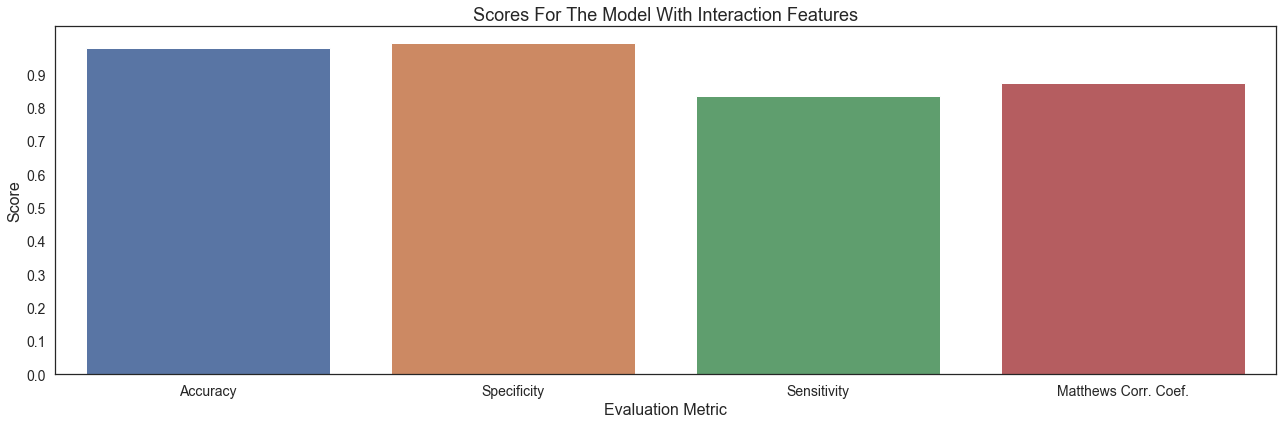

In [44]:
graphs.barplot(df     = scores,
               x      = scores.index,
               y      = "Interaction Features",
               title  = "Scores For The Model With Interaction Features",
               label  = "Evaluation Metric",
               ylabel = "Score",
               ticks  = np.arange(0, 1, 0.1),
               dim    = (18,6))

- `Balanced Accuracy` is high because it considers the sensitivity of both classes.  It isn't surprising that it is better than the baseline because the baseline is so low.


- `Specificity` is the highest score because the most of the data is composed of the negative class.


- `Sensitivity` is the lowest score because so few of the data represents pulsars.


- `F1 Score` considers both sensitivity and specificity, which is why the score isn't higher.

#### ROC Curve

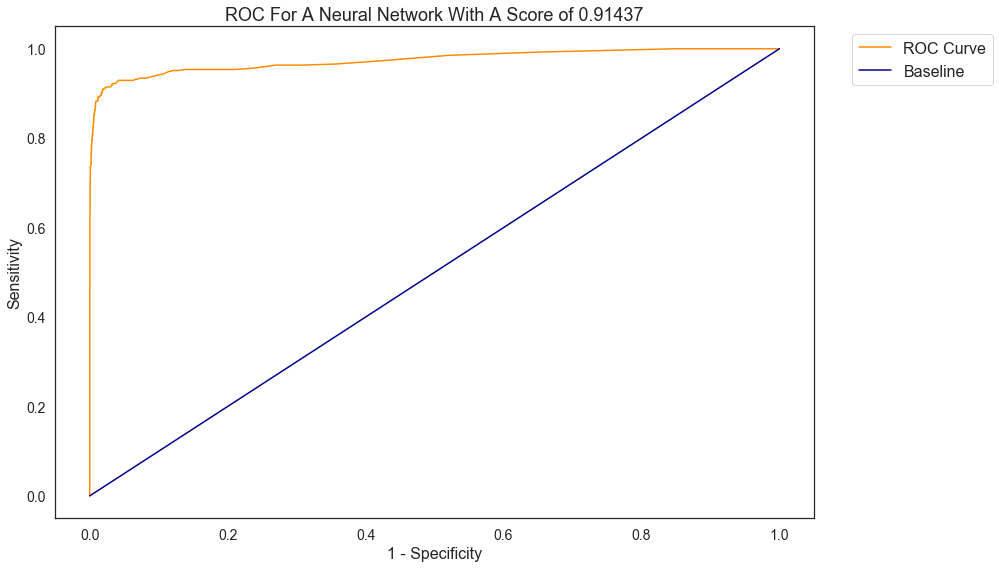

In [45]:
graphs.roc_curve(model_prob  = if_model,
                 X_test      = X_if_test,
                 y_test      = y_if_test,
                 y_predicted = if_test_preds,
                 title       = "ROC For A Neural Network",
                 dim         = (14,8))

The ROC curve is a representation of the relationship between the true positives and the false positives.

The low score indicates that the model is good at predicting the two classes, which we also saw from the confusion matrices.  In an ideal world, we would have perfect 90º angle but ours is _extremely_ close to that which indicates our classes are significantly distinct.

[Top](#Table-Of-Contents)